In [1]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import lasso_regression, hs_regression
from pymc_utils import plot_fits_w_estimates
from pymc_utils import plot_fits_with_unc
# note that in addition to these packages the user will need to install graphviz
# and python-graphviz, both through anaconda (conda install <pkg-name>)

In [84]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    scatter_lbl = scatter_kwds.pop('label', '')
    scatter_lbl = fr'{scatter_lbl}$r^2$={r2:.2f}, mae={mae:.2f}'
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax


def plot_fits_w_estimates(y_obs, ppc, ax=None, legend=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean = ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    r2 = r2_score(y_obs, lik_mean)
    mae = mean_absolute_error(y_obs, lik_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean -- $r^2$=%.2f -- mae=%.2f' %(r2, mae),
               edgecolor='k', s=100, color='m', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    if legend:
        ax.legend(loc='upper left');
    return ax

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [3]:
with open('./pickleJar/BNNAphySplitDataSets.pkl', 'rb') as fb:
    datadict = pickle.load(fb)
X_s_train = datadict['x_train_s']
y_train = datadict['y_train']
X_s_test = datadict['x_test_s']
y_test = datadict['y_test']

In [4]:
X_s_train.head()

,log10_etopo2_s,oisst_s,solz_s,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s
104,1.561812,0.980019,-0.652818,0.189974,-0.414644,-0.933887,-0.510384,0.285450,0.064361
98,1.667105,-0.455988,-0.472027,0.579478,-0.554825,-0.349339,-0.066203,-1.129648,0.660823
16,-0.768789,-0.912078,0.498893,-0.484867,0.421179,-0.301039,0.747057,-0.227188,-0.363760
75,-0.742689,1.387941,-0.873786,0.084072,-0.869452,-0.196910,1.052647,0.434195,-0.296654
18,-1.067195,0.055796,1.208669,-1.146327,2.335666,-1.018783,-0.174597,1.969049,-1.271384


In [5]:
y_train.head()

,log10_aphy411,log10_aphy443,log10_aphy489,log10_aphy510,log10_aphy555,log10_aphy670
104,-1.734239,-1.606952,-1.803547,-2.036684,-2.583359,-2.212540
98,-1.991400,-1.887730,-2.030118,-2.274088,-2.879426,-2.317855
16,-1.571217,-1.526367,-1.676542,-1.888737,-2.399027,-1.963371
75,-1.635824,-1.574792,-1.764977,-2.003488,-2.480172,-2.336299
18,-1.571217,-1.517269,-1.740884,-1.988430,-2.444906,-2.191789


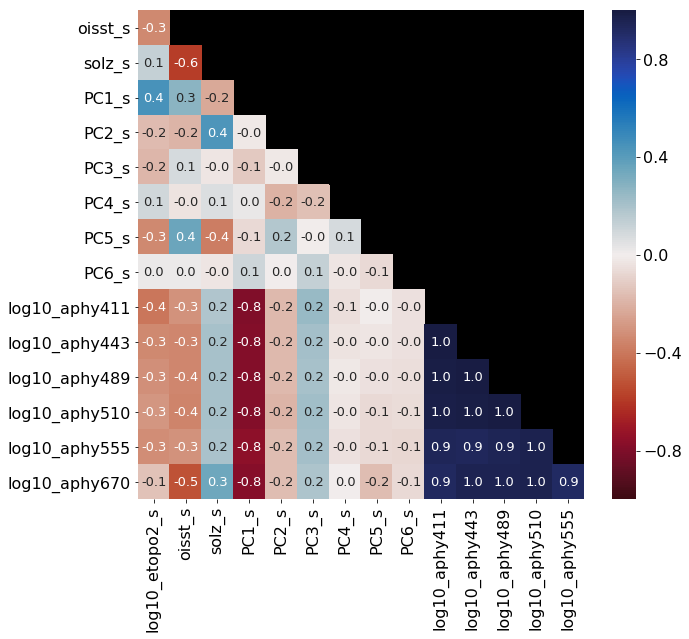

In [7]:
f, ax = pl.subplots(figsize=(10, 9))
ax = PlotHeatMap(pd.concat((X_s_train, y_train), axis=1), ax=ax)
#f.savefig('./figJar/aphy_heatmap.png', dpi=150, format='png')

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [7]:
# prep labelling:
Y_LBL = 'likelihood'
feature_labels=X_s_train.columns.tolist()

### A$\phi$ 411 - Regularized Horseshoe

In [8]:
X_shared = shared(X_s_train.values)

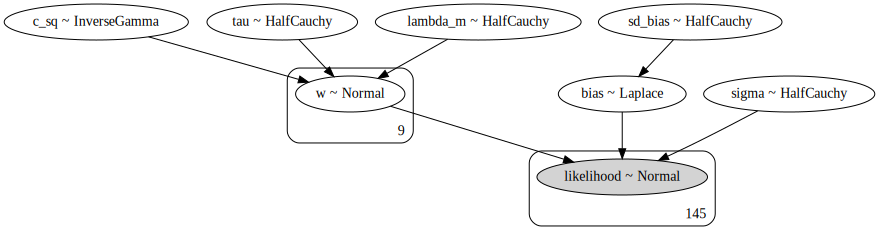

In [9]:
m_hshoe_411 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy411.values,
                        model_name='hshoe_aphy411',
                        ylabel=Y_LBL, regularized=True)
m_hshoe_411.show_model()

In [11]:
m_hshoe_411.fit(tune=10000,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:38<00:00, 487.09draws/s]
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5472879758813708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9335704640538577, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


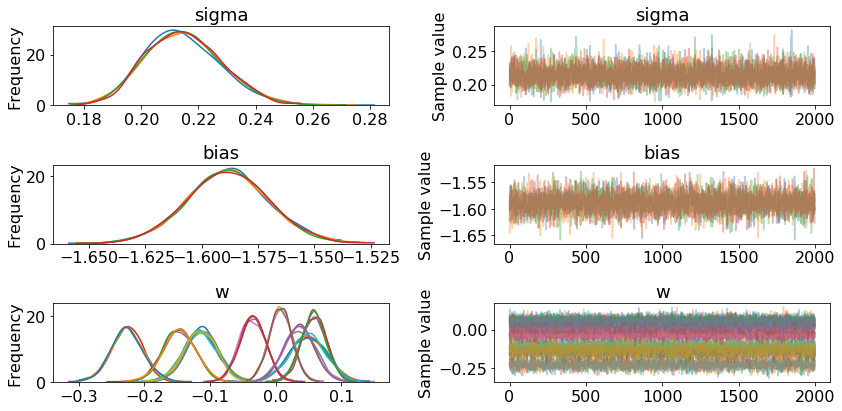

In [12]:
m_hshoe_411.evaluate_fit(['sigma',  'bias', 'w']);

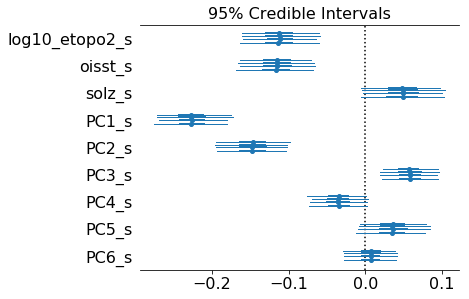

In [13]:
pm.forestplot(m_hshoe_411.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy411.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1070.75it/s]


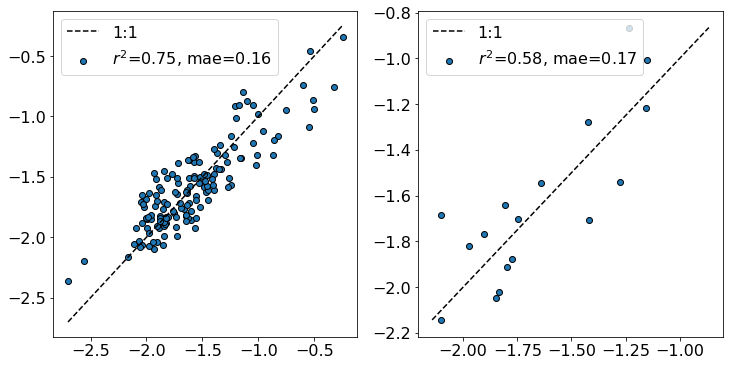

In [14]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
#X_shared.set_value(X_s_train)
ppc_train_411 = m_hshoe_411.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy411, ppc_train_411, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_411 = m_hshoe_411.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, plot_1_to_1=True, ax=ax[1])

In [32]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict = {m_hshoe_411.model.name: dict(model=m_hshoe_411.model,
                                                 trace=m_hshoe_411.trace_,
                                              ppc_train=ppc_train_411,
                                              ppc_test=ppc_test_411)
                 }
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

### A$\phi$ 443

In [18]:

m_hshoe_443 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy443, model_name='hshoe_aphy443',
                        ylabel='likelihood', regularized=True)
m_hshoe_443.fit(tune=10000, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:37<00:00, 307.38draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6683244681496086, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


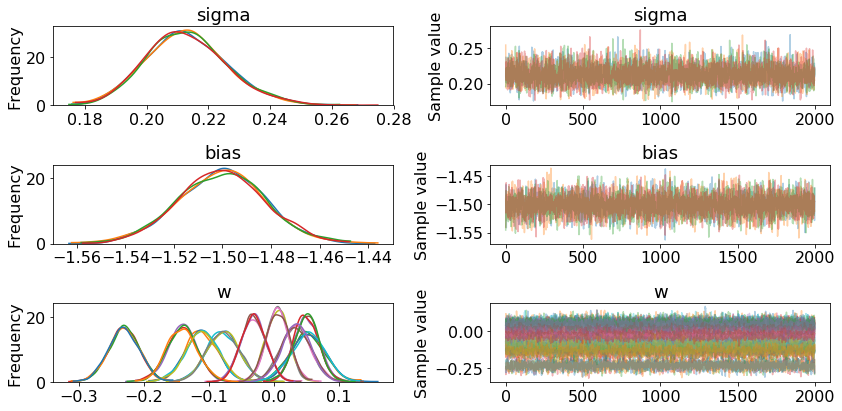

In [19]:
m_hshoe_443.evaluate_fit(['sigma',  'bias', 'w']);

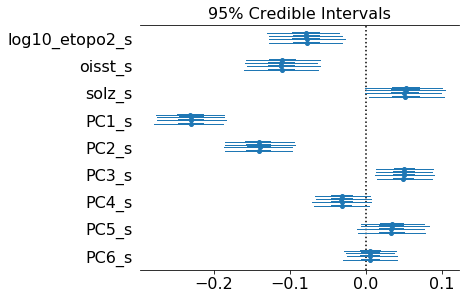

In [20]:
pm.forestplot(m_hshoe_443.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy443.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1059.32it/s]


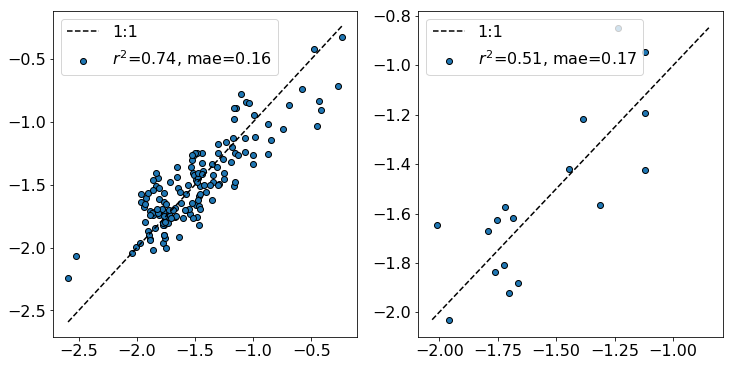

In [21]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
#X_shared.set_value(X_s_train)
ppc_train_443 = m_hshoe_443.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy443, ppc_train_443, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_443 = m_hshoe_443.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, plot_1_to_1=True, ax=ax[1])

In [34]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict[m_hshoe_443.model.name] = dict(model=m_hshoe_443.model,
                                              trace=m_hshoe_443.trace_,
                                              ppc_train=ppc_train_443,
                                              ppc_test=ppc_test_443)
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

### A$\phi$ 489

In [22]:
X_shared.set_value(X_s_train.values)
m_hshoe_489 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy489, model_name='hshoe_aphy489',
                        ylabel='likelihood', regularized=True)
m_hshoe_489.fit(tune=10000, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:34<00:00, 507.08draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6019032430807014, but should be close to 0.8. Try to increase the number of tuning steps.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5677231773753617, but should be close to 0.8. Try to increase the number of tuning steps.


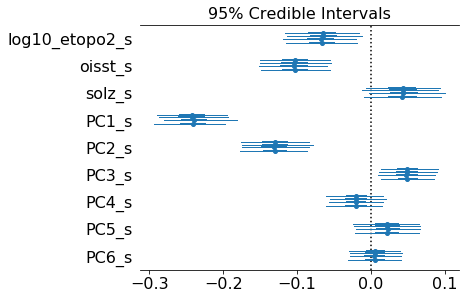

In [23]:
pm.forestplot(m_hshoe_489.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy489.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1061.14it/s]


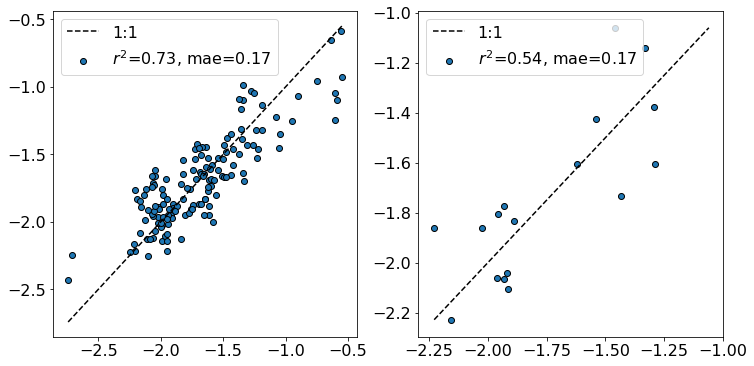

In [24]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
#X_shared.set_value(X_s_train)
ppc_train_489 = m_hshoe_489.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy489, ppc_train_489, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_489 = m_hshoe_489.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, plot_1_to_1=True, ax=ax[1])

In [35]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict[m_hshoe_489.model.name] = dict(model=m_hshoe_489.model,
                                              trace=m_hshoe_489.trace_,
                                              ppc_train=ppc_train_489,
                                              ppc_test=ppc_test_489)
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
X_shared.set_value(X_s_train.values)
m_hshoe_510 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy510, model_name='hshoe_aphy510',
                        ylabel='likelihood', regularized=True)
m_hshoe_510.fit(tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:43<00:00, 464.84draws/s]
The acceptance probability does not match the target. It is 0.9284572991499751, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893614847204348, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 465 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3084092823569263, but should be close to 0.8. Try to increase the number of tuning steps.


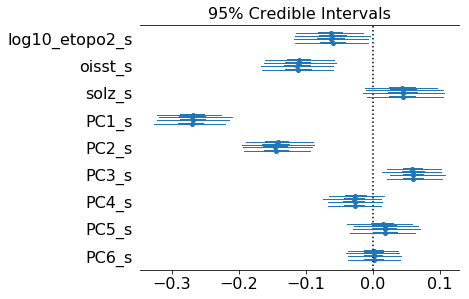

In [26]:
pm.forestplot(m_hshoe_510.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy510.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1066.38it/s]


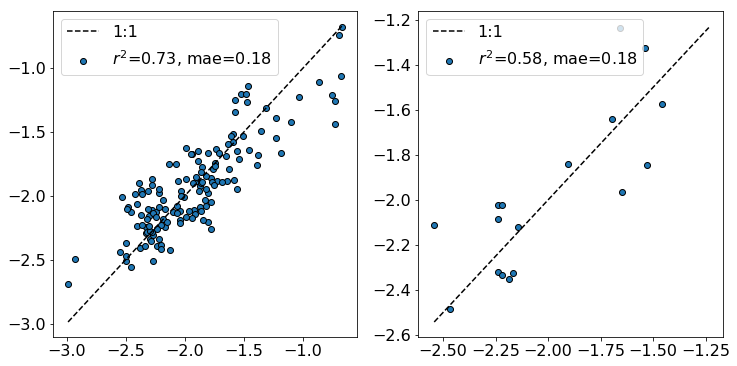

In [85]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
X_shared.set_value(X_s_train)
ppc_train_510 = m_hshoe_510.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy510, ppc_train_510, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_510 = m_hshoe_510.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, plot_1_to_1=True, ax=ax[1])

In [36]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict[m_hshoe_510.model.name] = dict(model=m_hshoe_510.model,
                                              trace=m_hshoe_510.trace_,
                                              ppc_train=ppc_train_510,
                                              ppc_test=ppc_test_510)
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
m_hshoe_555 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy555, model_name='hshoe_aphy555',
                        ylabel='likelihood', regularized=True)
m_hshoe_555.fit(tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:37<00:00, 490.75draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9191544359380122, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


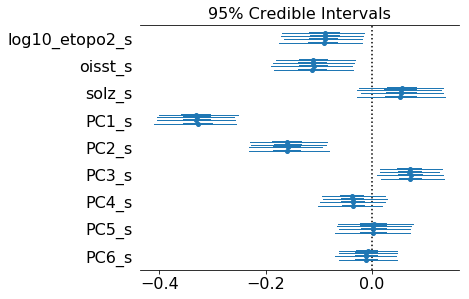

In [38]:
pm.forestplot(m_hshoe_555.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy555.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1068.48it/s]


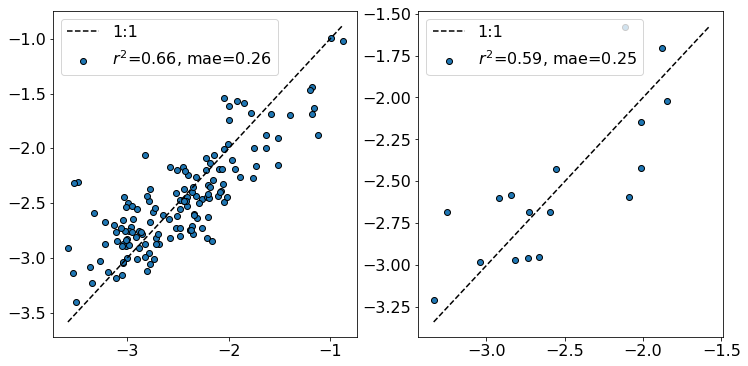

In [39]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
#X_shared.set_value(X_s_train)
ppc_train_555 = m_hshoe_555.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy555, ppc_train_555, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_555 = m_hshoe_555.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, plot_1_to_1=True, ax=ax[1])

In [40]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict[m_hshoe_555.model.name] = dict(model=m_hshoe_555.model,
                                              trace=m_hshoe_555.trace_,
                                              ppc_train=ppc_train_555,
                                              ppc_test=ppc_test_555)
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
m_hshoe_670 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy670, model_name='hshoe_aphy670',
                        ylabel='likelihood', regularized=True)
m_hshoe_670.fit(tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:40<00:00, 479.47draws/s]
The acceptance probability does not match the target. It is 0.90991740685572, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6920156587918963, but should be close to 0.8. Try to increase the number of tuning steps.


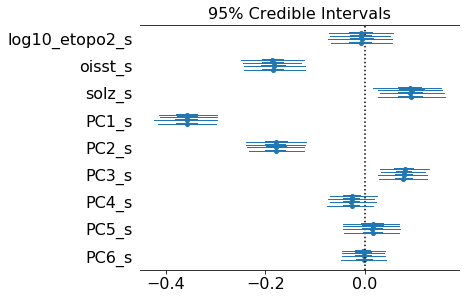

In [42]:
pm.forestplot(m_hshoe_670.trace_, varnames=['w'], ylabels=feature_labels, rhat=False)
f = pl.gcf()
f.savefig('./figJar/foresplot_hs_reg_aphy670.png', dpi=300, format='png')

100%|██████████| 8000/8000 [00:07<00:00, 1060.88it/s]


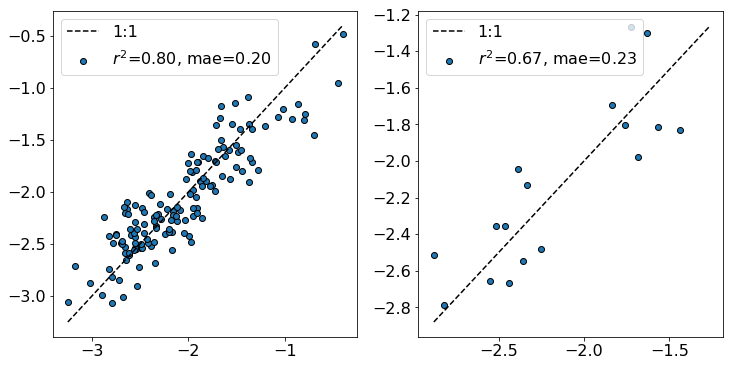

In [43]:
# Check fit on training model
_, ax= pl.subplots(ncols=2, figsize=(12, 6))
#X_shared.set_value(X_s_train)
ppc_train_670 = m_hshoe_670.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_train.log10_aphy670, ppc_train_670, plot_1_to_1=True, ax=ax[0])
X_shared.set_value(X_s_test)
ppc_test_670 = m_hshoe_670.predict(likelihood_name=Y_LBL)
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, plot_1_to_1=True, ax=ax[1])

In [97]:
X_shared.set_value(X_s_train.values)
hshoe_mdl_dict[m_hshoe_670.model.name] = dict(model=m_hshoe_670.model,
                                              trace=m_hshoe_670.trace_,
                                              ppc_train=ppc_train_670,
                                              ppc_test=ppc_test_670)
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'wb') as fb:
    pickle.dump(hshoe_mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
with open('./pickleJar/Hshoe_example_model.pkl', 'wb') as fb:
    pickle.dump(m_hshoe_411, fb, protocol=pickle.HIGHEST_PROTOCOL)

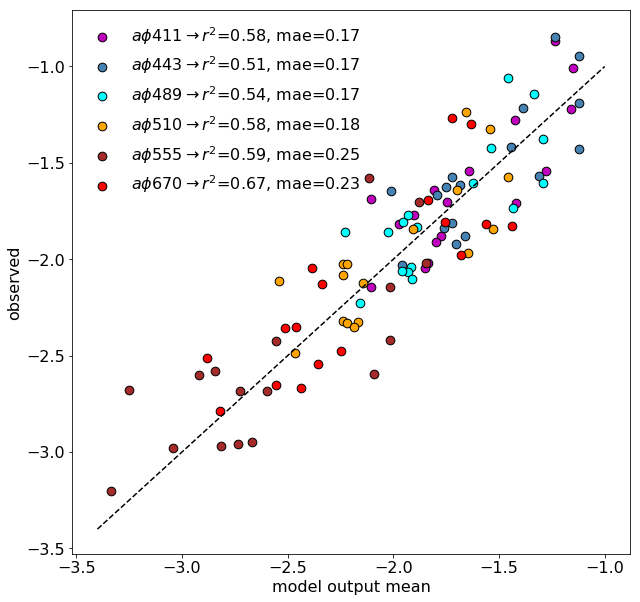

In [96]:
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411,
                     color='m', s=75, ax=ax_, label=r'$a\phi411 \rightarrow$') 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, s=75,
                     color='steelblue', ax=ax_, label=r'$a\phi443 \rightarrow$', 
                    )
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, s=75,
                     color='cyan', ax=ax_, label=r'$a\phi489 \rightarrow$', )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, s=75,
                     color='orange', ax=ax_, label=r'$a\phi510 \rightarrow$')
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, s=75, 
                     color='brown', ax=ax_, label=r'$a\phi555 \rightarrow$')
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, s=75,
                     color='red', ax=ax_, label=r'$a\phi670 \rightarrow$')
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend(loc='upper left', frameon=False)
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.savefig('./figJar/HorseShoePrior_aphi_test_sets.pdf', format='pdf', dpi=300)

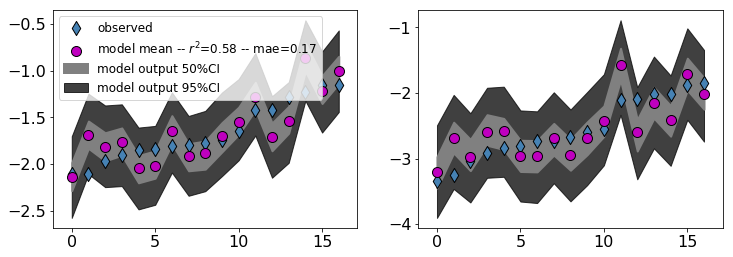

In [57]:
f, axs = pl.subplots(ncols=2, sharey=False, figsize=(12, 4))
plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, ax=axs[0])
plot_fits_w_estimates(y_test.log10_aphy555, ppc_test_555, ax=axs[1])
axs[0].legend(fontsize=12,frameon=False)